## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 10 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.25, 0.3]
redice_lr_patient = [0, 5]

In [8]:
import itertools
from keras.callbacks import ReduceLROnPlateau

results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """

    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.25, reduce_patient: 0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizatio

Epoch 8/10
50000/50000 [==============================] - 2s 41us/step - loss: 1.3944 - acc: 0.5109 - val_loss: 1.5290 - val_acc: 0.4612
Epoch 9/10
50000/50000 [==============================] - 2s 41us/step - loss: 1.3647 - acc: 0.5218 - val_loss: 1.5246 - val_acc: 0.4639
Epoch 10/10
50000/50000 [==============================] - 2s 41us/step - loss: 1.3394 - acc: 0.5305 - val_loss: 1.5094 - val_acc: 0.4713
Numbers of exp: 3, reduce_factor: 0.30, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_10 (Batc (None, 256)               1024      
_________________________________________________________________
hi

50000/50000 [==============================] - 3s 52us/step - loss: 1.7749 - acc: 0.3863 - val_loss: 1.8398 - val_acc: 0.3676
Epoch 4/10
50000/50000 [==============================] - 2s 48us/step - loss: 1.7098 - acc: 0.4055 - val_loss: 1.7810 - val_acc: 0.3846
Epoch 5/10
50000/50000 [==============================] - 2s 43us/step - loss: 1.6642 - acc: 0.4219 - val_loss: 1.7414 - val_acc: 0.3951
Epoch 6/10
50000/50000 [==============================] - 2s 44us/step - loss: 1.6270 - acc: 0.4338 - val_loss: 1.7153 - val_acc: 0.4050
Epoch 7/10
50000/50000 [==============================] - 2s 45us/step - loss: 1.5976 - acc: 0.4414 - val_loss: 1.7013 - val_acc: 0.4112
Epoch 8/10
50000/50000 [==============================] - 2s 45us/step - loss: 1.5703 - acc: 0.4515 - val_loss: 1.6832 - val_acc: 0.4210
Epoch 9/10
50000/50000 [==============================] - 2s 45us/step - loss: 1.5462 - acc: 0.4611 - val_loss: 1.6597 - val_acc: 0.4225
Epoch 10/10
50000/50000 [===========================

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 4s 81us/step - loss: 1.8344 - acc: 0.3664 - val_loss: 3.2696 - val_acc: 0.2300
Epoch 2/10
50000/50000 [==============================] - 2s 45us/step - loss: 1.5468 - acc: 0.4528 - val_loss: 8.8653 - val_acc: 0.1243

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 3/10
50000/50000 [==============================] - 2s 44us/step - loss: 1.3463 - acc: 0.5286 - val_loss: 1.8103 - val_acc: 0.3666
Epoch 4/10
50000/50000 [==============================] - 2s 45us/step - loss: 1.2811 - acc: 0.5555 - val_loss: 1.5186 - val_acc: 0.4544
Epoch 5/10
50000/50000 [==============================] - 2s 45us/step - loss: 1.2331 - acc: 0.5705 - val_loss: 1.6385 - val_acc: 0.4158

Epoch 00005: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 6/10
50000/50000 [==============================] - 2s 45us/step - loss: 1.1726 - acc: 0.5940 - va

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 4s 84us/step - loss: 2.7864 - acc: 0.1378 - val_loss: 2.6192 - val_acc: 0.1739
Epoch 2/10
50000/50000 [==============================] - 2s 45us/step - loss: 2.4984 - acc: 0.1977 - val_loss: 2.4522 - val_acc: 0.2122
Epoch 3/10
50000/50000 [==============================] - 2s 45us/step - loss: 2.3325 - acc: 0.2357 - val_loss: 2.3412 - val_acc: 0.2406
Epoch 4/10
50000/50000 [==============================] - 2s 45us/step - loss: 2.2208 - acc: 0.2635 - val_loss: 2.2534 - val_acc: 0.2650
Epoch 5/10
50000/50000 [==============================] - 2s 45us/step - loss: 2.1374 - acc: 0.2839 - val_loss: 2.1739 - val_acc: 0.2830
Epoch 6/10
50000/50000 [==============================] - 2s 45us/step - loss: 2.0713 - acc: 0.3010 - val_loss: 2.1138 - val_acc: 0.2973
Epoch 7/10
50000/50000 [==============================] - 2s 45us/step - loss: 2.0183 - acc: 0.3152 - val_loss: 2.0664 - val_acc

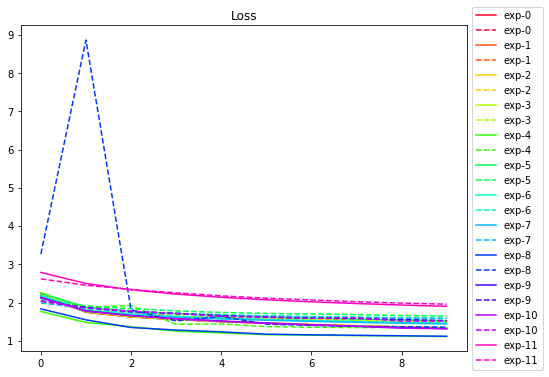

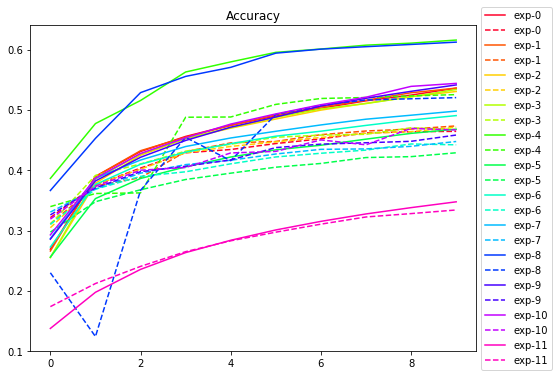

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()